In [17]:
#pip install qiskit qiskit-machine-learning qiskit-algorithms

In [18]:
"""
Heart Disease Prediction using Classical and Quantum Machine Learning

This script performs analysis on the 'Heart Prediction Quantum Dataset.csv'.
It includes:
1. Data Loading and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Classical Machine Learning Model Tuning and Evaluation
4. Quantum Support Vector Machine (QSVM) Implementation and Evaluation
5. Classical SVM Baseline Comparison
6. Results Visualization and Comparison
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings
import os
import sys

# Classical ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC as ClassicalSVC

# Qiskit Imports
try:
    from qiskit.primitives import Sampler
    from qiskit.circuit.library import ZZFeatureMap
    from qiskit_algorithms.state_fidelities import ComputeUncompute
    from qiskit_machine_learning.kernels import FidelityQuantumKernel
    from qiskit_machine_learning.algorithms import QSVC
    qiskit_available = True
except ImportError:
    print("------------------------------------------------------")
    print("WARNING: Qiskit libraries not found.")
    print("Quantum SVM (QSVM) parts will be skipped.")
    print("Install with: pip install qiskit qiskit-machine-learning qiskit-algorithms")
    print("------------------------------------------------------")
    qiskit_available = False

In [19]:
# --- Configuration ---
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
np.random.seed(42) # for reproducibility
DATASET_PATH = "/kaggle/input/heart-prediction-dataset-quantum/Heart Prediction Quantum Dataset.csv"
TEST_SIZE = 0.20
RANDOM_STATE = 42
N_ITER_RANDOM_SEARCH = 20 # Number of iterations for RandomizedSearchCV
CV_FOLDS = 5



In [20]:
# --- Helper Functions ---

def plot_confusion_matrix_heatmap(y_true, y_pred, title):
    """Plots a confusion matrix using seaborn heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    # plt.savefig(f"{title.replace(' ', '_')}_cm.png") # Optional: Save figure
    plt.show()


In [21]:

# --- Core Functions ---

def load_and_preprocess_data(filepath):
    """Loads the dataset, handles basic preprocessing, and splits it."""
    print(f"\n--- 1. Data Loading and Preprocessing ---")
    print(f"Loading data from {filepath}...")
    if not os.path.exists(filepath):
        print(f"Error: Dataset file not found at {filepath}")
        sys.exit(1) # Exit if data is not found

    df = pd.read_csv(filepath)
    print("Original data sample:\n", df.head())
    print("\nData Info:")
    df.info()

    # --- Basic Checks ---
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nDuplicate rows: {df.duplicated().sum()}")

    # --- Preprocessing ---
    # Ensure Gender is numeric (0/1) - assumes 0: Female, 1: Male based on typical encoding
    if 'Gender' in df.columns:
        if df['Gender'].dtype == 'object':
            gender_map = {'Male': 1, 'Female': 0}
            if set(df['Gender'].unique()) <= set(gender_map.keys()):
                df['Gender'] = df['Gender'].map(gender_map)
                print("\nMapped 'Gender' column to numeric (Female: 0, Male: 1).")
            else:
                print("\nWarning: 'Gender' column has unexpected values. Keeping as is if numeric, otherwise check.")
        elif not pd.api.types.is_numeric_dtype(df['Gender']):
             print("\nWarning: 'Gender' column exists but is not numeric or standard categorical. Check data.")
    else:
         print("\nWarning: 'Gender' column not found.")


    # Define features (X) and target (y)
    if 'HeartDisease' not in df.columns:
        print("\nError: Target column 'HeartDisease' not found.")
        sys.exit(1)

    # Ensure all feature columns are numeric
    feature_cols = df.drop('HeartDisease', axis=1).columns
    X_original = df[feature_cols].copy() # Keep original for EDA
    X = df[feature_cols].apply(pd.to_numeric, errors='coerce')
    if X.isnull().sum().sum() > 0:
        print("\nWarning: Coerced non-numeric features to NaN. Imputing with mean.")
        X = X.fillna(X.mean())

    y = df['HeartDisease']

    print(f"\nFeatures used ({X.shape[1]}): {list(X.columns)}")
    print(f"Target: HeartDisease")
    print(f"Class distribution (0: No Disease, 1: Disease):\n{y.value_counts(normalize=True)}")

    # --- Scaling ---
    print("\nScaling features using MinMaxScaler to [0, 1] range...")
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # For potential later use

    # --- Train/Test Split ---
    print(f"Splitting data ({1-TEST_SIZE:.0%} train, {TEST_SIZE:.0%} test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape:  X={X_test.shape}, y={y_test.shape}")

    return X_train, X_test, y_train, y_test, X.columns, df # Return original df for EDA



In [22]:
def perform_eda(df_original):
    """Performs Exploratory Data Analysis and generates plots."""
    print("\n--- 2. Exploratory Data Analysis (EDA) ---")

    # Create a copy for EDA modifications if needed
    data_eda = df_original.copy()

    # Ensure Gender is numeric for correlation
    if 'Gender' in data_eda.columns and data_eda['Gender'].dtype != 'object':
        # If already numeric, great. If not and mapping failed earlier, correlation might skip it.
        pass
    elif 'Gender' in data_eda.columns: # If it's object type, try mapping again for EDA scope
         gender_map = {'Male': 1, 'Female': 0}
         if set(data_eda['Gender'].unique()) <= set(gender_map.keys()):
             data_eda['Gender'] = data_eda['Gender'].map(gender_map)


    # 1. Histograms for numerical features
    print("Plotting distributions of numerical features...")
    fig_hist, axes_hist = plt.subplots(2, 2, figsize=(12, 10))
    num_cols = ['Age', 'BloodPressure', 'Cholesterol', 'HeartRate']
    for i, col in enumerate(num_cols):
        if col in data_eda.columns:
            sns.histplot(data_eda[col], bins=20, kde=True, ax=axes_hist[i // 2, i % 2], color='darkblue')
            axes_hist[i // 2, i % 2].set_title(f'Distribution of {col}')
        else:
             axes_hist[i // 2, i % 2].set_title(f'{col} not found')
             axes_hist[i // 2, i % 2].axis('off')
    plt.suptitle('Histograms of Numerical Features', y=1.02)
    plt.tight_layout()
    plt.show()

    # 2. Boxplots for numerical features
    print("Plotting boxplots of numerical features...")
    plt.figure(figsize=(12, 6))
    if all(col in data_eda.columns for col in num_cols):
        sns.boxplot(data=data_eda[num_cols], palette='coolwarm')
        plt.title('Boxplot of Numerical Features')
    else:
         plt.title('Boxplot Skipped - Some numerical columns missing')
    plt.show()

    # 3. Correlation Heatmap
    print("Plotting feature correlation heatmap...")
    plt.figure(figsize=(8, 6))
    # Calculate correlation only on numeric types within the EDA scope
    numeric_df_eda = data_eda.select_dtypes(include=np.number)
    if not numeric_df_eda.empty:
        corr = numeric_df_eda.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Feature Correlation Heatmap')
    else:
         plt.title('Correlation Heatmap Skipped - No numeric columns found')
    plt.show()

    # 4. Violin Plots by Heart Disease
    print("Plotting distributions by Heart Disease status...")
    fig_violin, axes_violin = plt.subplots(1, 2, figsize=(12, 5))
    if 'BloodPressure' in data_eda.columns and 'HeartDisease' in data_eda.columns:
        sns.violinplot(x='HeartDisease', y='BloodPressure', data=data_eda, ax=axes_violin[0], palette='muted')
        axes_violin[0].set_title('Blood Pressure Distribution by Heart Disease')
    else:
        axes_violin[0].set_title('BloodPressure/HeartDisease not found')
        axes_violin[0].axis('off')

    if 'Cholesterol' in data_eda.columns and 'HeartDisease' in data_eda.columns:
        sns.violinplot(x='HeartDisease', y='Cholesterol', data=data_eda, ax=axes_violin[1], palette='muted')
        axes_violin[1].set_title('Cholesterol Distribution by Heart Disease')
    else:
        axes_violin[1].set_title('Cholesterol/HeartDisease not found')
        axes_violin[1].axis('off')

    plt.suptitle('Numerical Feature Distributions by Heart Disease', y=1.02)
    plt.tight_layout()
    plt.show()

    # 5. KDE Plot for Heart Rate by Heart Disease
    if 'HeartRate' in data_eda.columns and 'HeartDisease' in data_eda.columns:
        print("Plotting Heart Rate density by Heart Disease status...")
        plt.figure(figsize=(8, 5))
        sns.kdeplot(data=data_eda, x='HeartRate', hue='HeartDisease', fill=True, palette='coolwarm')
        plt.title('Heart Rate Density by Heart Disease')
        plt.show()

    # 6. Scatter Plots involving QuantumPatternFeature
    if 'QuantumPatternFeature' in data_eda.columns and 'HeartDisease' in data_eda.columns:
        print("Plotting Quantum Pattern Feature relationships...")
        fig_scatter, axes_scatter = plt.subplots(1, 2, figsize=(12, 5))
        scatter_y_cols = ['BloodPressure', 'Cholesterol']
        for i, y_col in enumerate(scatter_y_cols):
            if y_col in data_eda.columns:
                 sns.scatterplot(x='QuantumPatternFeature', y=y_col, hue='HeartDisease', data=data_eda, ax=axes_scatter[i], palette='Set2')
                 axes_scatter[i].set_title(f'Quantum Pattern Feature vs {y_col}')
            else:
                 axes_scatter[i].set_title(f'{y_col} not found')
                 axes_scatter[i].axis('off')
        plt.suptitle('Quantum Pattern Feature vs Clinical Indicators', y=1.02)
        plt.tight_layout()
        plt.show()

    print("--- EDA Finished ---")




In [23]:
def tune_and_evaluate_classical_models(X_train, X_test, y_train, y_test):
    """Tunes hyperparameters and evaluates classical models."""
    print("\n--- 3. Classical Machine Learning Models ---")
    print("Setting up models and hyperparameter grids...")

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE), # Increased max_iter for convergence
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
        "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
        "Naive Bayes": GaussianNB(),
        "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
    }

    # Adjusted Param Grid (Removed incompatible solver/penalty combos for Logistic Regression)
    param_grid = {
        "Random Forest": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False]
        },
        "Decision Tree": {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        },
        "K-Nearest Neighbors": {
            "n_neighbors": [3, 5, 7, 9, 11],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        },
        "Logistic Regression": {
             # Using solvers compatible with penalties
             'solver': ['liblinear', 'saga'],
             'penalty': ['l1', 'l2'], # liblinear supports l1/l2, saga supports l1/l2/elasticnet/none
             'C': [0.01, 0.1, 1, 10, 100]
             # 'penalty': ['l2', None], 'solver': ['lbfgs'], 'C': [0.01, 0.1, 1, 10, 100] # lbfgs specific grid part
        },
        "Naive Bayes": {
            "var_smoothing": [1e-10, 1e-9, 1e-8, 1e-7]
        },
        "Gradient Boosting": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 5, 8],
            "subsample": [0.7, 0.8, 0.9]
        }
    }

    best_estimators = {}
    results = {}
    tuning_times = {}

    print(f"Performing RandomizedSearchCV (n_iter={N_ITER_RANDOM_SEARCH}, cv={CV_FOLDS})...")
    for model_name, model in models.items():
        start_time = time.time()
        print(f"\nTuning {model_name}...")
        # Handle Logistic Regression solver/penalty combinations carefully
        current_param_grid = param_grid[model_name]
        if model_name == "Logistic Regression":
             # Create specific grids for solver compatibility if necessary,
             # or ensure the combinations in the main grid are valid.
             # For simplicity, we assume the grid above has compatible combos.
             pass

        param_search = RandomizedSearchCV(
            model, current_param_grid,
            n_iter=N_ITER_RANDOM_SEARCH, scoring='accuracy',
            cv=CV_FOLDS, random_state=RANDOM_STATE, n_jobs=-1, error_score='raise' # Raise error on invalid combos
        )
        try:
            param_search.fit(X_train, y_train)
            best_estimators[model_name] = param_search.best_estimator_
            print(f"Best parameters: {param_search.best_params_}")

            # Evaluate on test set
            y_pred = best_estimators[model_name].predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            results[model_name] = {'accuracy': accuracy, 'report': report}

            print(f"{model_name} Test Accuracy: {accuracy:.4f}")
            print(classification_report(y_test, y_pred))
            plot_confusion_matrix_heatmap(y_test, y_pred, f"{model_name} Confusion Matrix")

        except ValueError as e:
             print(f"Skipping {model_name} due to incompatible parameters: {e}")
             results[model_name] = {'accuracy': None, 'report': None} # Mark as failed
             best_estimators[model_name] = None


        end_time = time.time()
        tuning_times[model_name] = end_time - start_time
        print(f"{model_name} tuning and evaluation took {tuning_times[model_name]:.2f} seconds.")

    print("\n--- Classical Model Tuning Finished ---")
    return best_estimators, results, tuning_times



In [24]:
def run_qsvm(X_train, X_test, y_train, y_test, num_features):
    """Sets up, trains, and evaluates the Quantum Support Vector Classifier."""
    print("\n--- 4. Quantum Machine Learning (QSVM) ---")
    if not qiskit_available:
        print("Skipping QSVM execution as Qiskit is not available.")
        return None, None # Return None if Qiskit isn't there

    results_qsvm = {}
    qsvm_times = {}

    try:
        # 1. Define Quantum Feature Map
        print(f"Setting up ZZFeatureMap with {num_features} features and reps=2...")
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement='linear')

        # 2. Define Quantum Kernel
        print("Setting up Sampler primitive and FidelityQuantumKernel...")
        sampler = Sampler()
        fidelity = ComputeUncompute(sampler=sampler)
        quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

        # 3. Instantiate and Train QSVC
        print("Instantiating and training QSVC (this may take time)...")
        qsvc_start_time = time.time()
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(X_train, y_train)
        qsvc_train_time = time.time() - qsvc_start_time
        qsvm_times['train'] = qsvc_train_time
        print(f"QSVC training completed in {qsvc_train_time:.2f} seconds.")

        # 4. Predict and Evaluate
        print("Predicting on test set...")
        qsvc_predict_start_time = time.time()
        y_pred_qsvc = qsvc.predict(X_test)
        qsvc_predict_time = time.time() - qsvc_predict_start_time
        qsvm_times['predict'] = qsvc_predict_time
        print(f"QSVC prediction completed in {qsvc_predict_time:.2f} seconds.")

        accuracy_qsvc = accuracy_score(y_test, y_pred_qsvc)
        report_qsvc = classification_report(y_test, y_pred_qsvc, output_dict=True)
        results_qsvm['QSVC'] = {'accuracy': accuracy_qsvc, 'report': report_qsvc}

        print("\nQSVC Performance:")
        print(f"Accuracy: {accuracy_qsvc:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred_qsvc))
        plot_confusion_matrix_heatmap(y_test, y_pred_qsvc, "QSVC Confusion Matrix")

        print("--- QSVM Finished ---")
        return results_qsvm, qsvm_times

    except Exception as e:
        print(f"\nError during QSVM execution: {e}")
        print("QSVM part failed.")
        return None, None




In [25]:
def run_classical_svm_baseline(X_train, X_test, y_train, y_test):
    """Trains and evaluates a classical SVM with RBF kernel for baseline."""
    print("\n--- 5. Classical SVM Baseline ---")
    results_svc = {}
    svc_times = {}

    # Instantiate and Train Classical SVC
    print("Instantiating and training classical SVC (RBF Kernel)...")
    svc_start_time = time.time()
    classical_svc = ClassicalSVC(kernel='rbf', gamma='scale', C=1.0, random_state=RANDOM_STATE)
    classical_svc.fit(X_train, y_train)
    svc_train_time = time.time() - svc_start_time
    svc_times['train'] = svc_train_time
    print(f"Classical SVC training completed in {svc_train_time:.2f} seconds.")

    # Predict and Evaluate
    print("Predicting on test set...")
    svc_predict_start_time = time.time()
    y_pred_svc = classical_svc.predict(X_test)
    svc_predict_time = time.time() - svc_predict_start_time
    svc_times['predict'] = svc_predict_time
    print(f"Classical SVC prediction completed in {svc_predict_time:.2f} seconds.")

    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    report_svc = classification_report(y_test, y_pred_svc, output_dict=True)
    results_svc['Classical SVC (RBF)'] = {'accuracy': accuracy_svc, 'report': report_svc}

    print("\nClassical SVC Performance:")
    print(f"Accuracy: {accuracy_svc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred_svc))
    plot_confusion_matrix_heatmap(y_test, y_pred_svc, "Classical SVC (RBF) Confusion Matrix")

    print("--- Classical SVM Baseline Finished ---")
    return results_svc, svc_times



In [26]:
def plot_model_comparison(classical_results, qsvm_results, svc_results):
    """Plots a comparison of model accuracies."""
    print("\n--- 6. Model Performance Comparison ---")

    accuracies = {}
    for model_name, result in classical_results.items():
        if result['accuracy'] is not None:
            accuracies[model_name] = result['accuracy']

    if qsvm_results and 'QSVC' in qsvm_results and qsvm_results['QSVC']['accuracy'] is not None:
         accuracies['QSVC (ZZFeatureMap)'] = qsvm_results['QSVC']['accuracy']

    if svc_results and 'Classical SVC (RBF)' in svc_results and svc_results['Classical SVC (RBF)']['accuracy'] is not None:
         accuracies['Classical SVC (RBF)'] = svc_results['Classical SVC (RBF)']['accuracy']

    if not accuracies:
        print("No model results available to plot.")
        return

    # Sort by accuracy
    sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=list(sorted_accuracies.keys()), y=list(sorted_accuracies.values()), palette="viridis")
    plt.ylabel("Accuracy Score")
    plt.xlabel("Model")
    plt.title("Model Accuracy Comparison on Test Set")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05) # Set y-axis limit from 0 to 1.05

    # Add accuracy labels on top of bars
    for i, v in enumerate(sorted_accuracies.values()):
        ax.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    # plt.savefig("model_accuracy_comparison.png") # Optional: Save figure
    plt.show()




In [27]:
# --- Main Execution ---
def main():
    """Main function to orchestrate the analysis."""
    print("Starting Heart Disease Prediction Analysis...")

    # 1. Load Data
    X_train, X_test, y_train, y_test, feature_names, df_original = load_and_preprocess_data(DATASET_PATH)

    # 2. Perform EDA
    perform_eda(df_original)

    # 3. Tune and Evaluate Classical Models
    best_estimators, classical_results, classical_times = tune_and_evaluate_classical_models(
        X_train, X_test, y_train, y_test
    )

    # 4. Run QSVM
    qsvm_results, qsvm_times = run_qsvm(X_train, X_test, y_train, y_test, X_train.shape[1])

    # 5. Run Classical SVM Baseline
    svc_results, svc_times = run_classical_svm_baseline(X_train, X_test, y_train, y_test)

    # 6. Compare Results
    plot_model_comparison(classical_results, qsvm_results, svc_results)

    # 7. Conclusion (Printed Summary)
    print("\n--- 7. Conclusion ---")
    print("Analysis complete. Classical models were tuned using RandomizedSearchCV.")
    print("QSVM using ZZFeatureMap and FidelityQuantumKernel was trained and evaluated.")
    print("Classical SVM with RBF kernel was used as a baseline.")
    print("Performance metrics (accuracy, classification reports) and confusion matrices were generated.")
    if qiskit_available and qsvm_results:
        print("\nNote on QSVM:")
        print(f"  - Training time: {qsvm_times.get('train', 'N/A'):.2f}s")
        print(f"  - Prediction time: {qsvm_times.get('predict', 'N/A'):.2f}s")
        print("  - This was run on a classical simulator. Performance on real quantum hardware may differ.")
        print("  - For this dataset size, classical methods are often faster and may perform comparably or better.")
    elif not qiskit_available:
         print("\nNote: QSVM execution was skipped as Qiskit libraries were not found.")

    print("\n--- Analysis Finished ---")


Starting Heart Disease Prediction Analysis...

--- 1. Data Loading and Preprocessing ---
Loading data from /kaggle/input/heart-prediction-dataset-quantum/Heart Prediction Quantum Dataset.csv...
Original data sample:
    Age  Gender  BloodPressure  Cholesterol  HeartRate  QuantumPatternFeature  \
0   68       1            105          191        107               8.362241   
1   58       0             97          249         89               9.249002   
2   44       0             93          190         82               7.942542   
3   72       1             93          183        101               6.495155   
4   37       0            145          166        103               7.653900   

   HeartDisease  
0             1  
1             0  
2             1  
3             1  
4             1  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------               

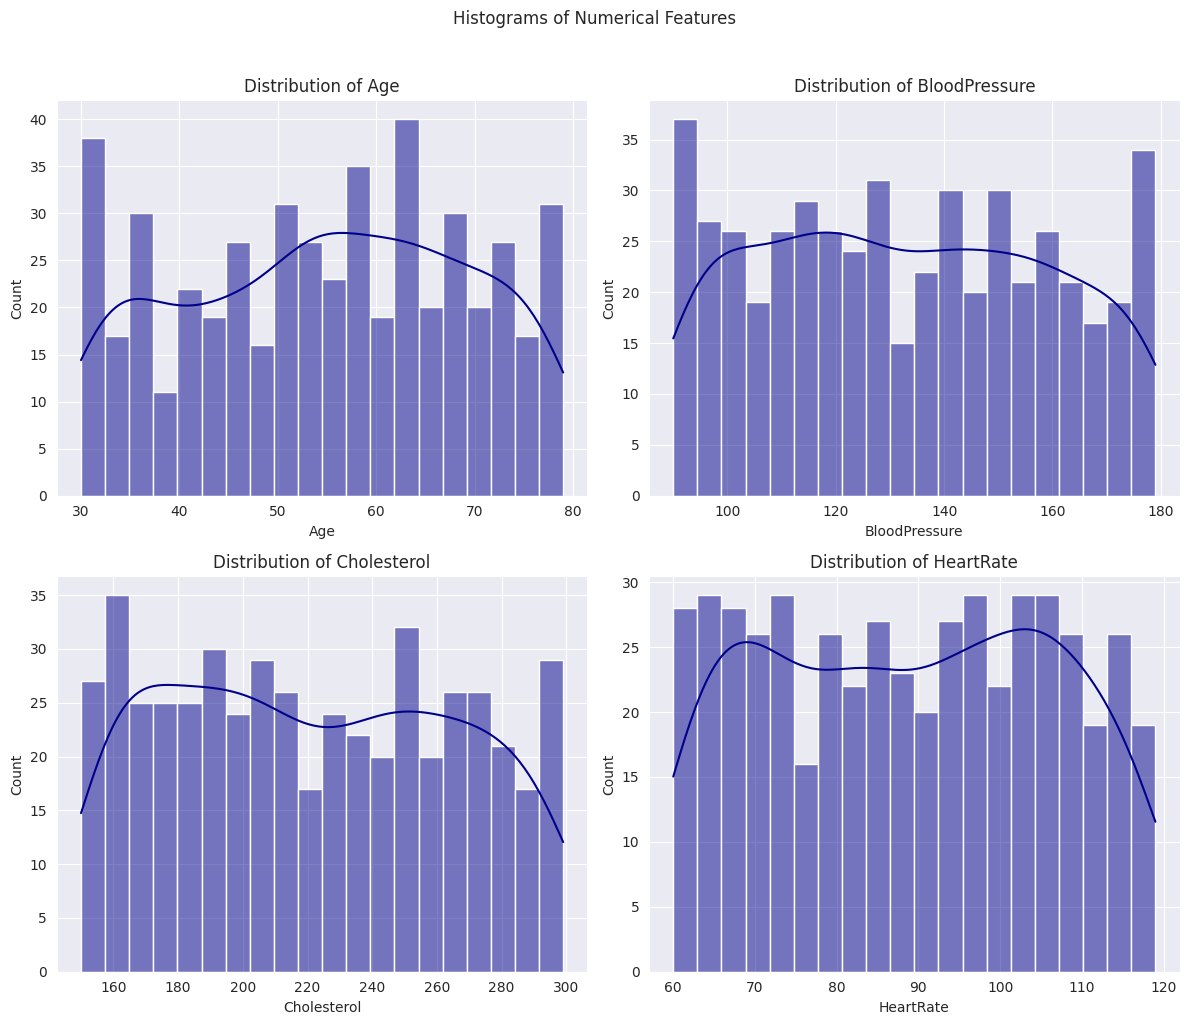

Plotting boxplots of numerical features...


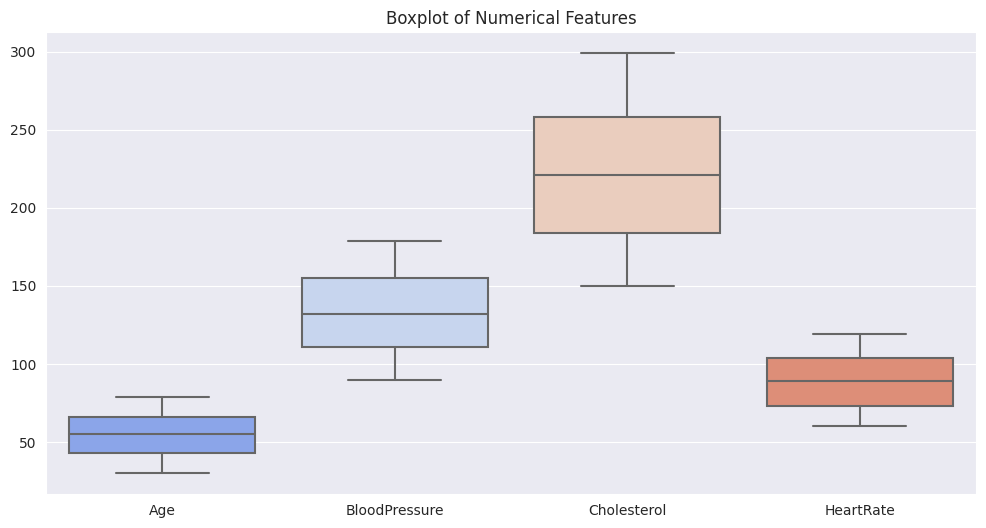

Plotting feature correlation heatmap...


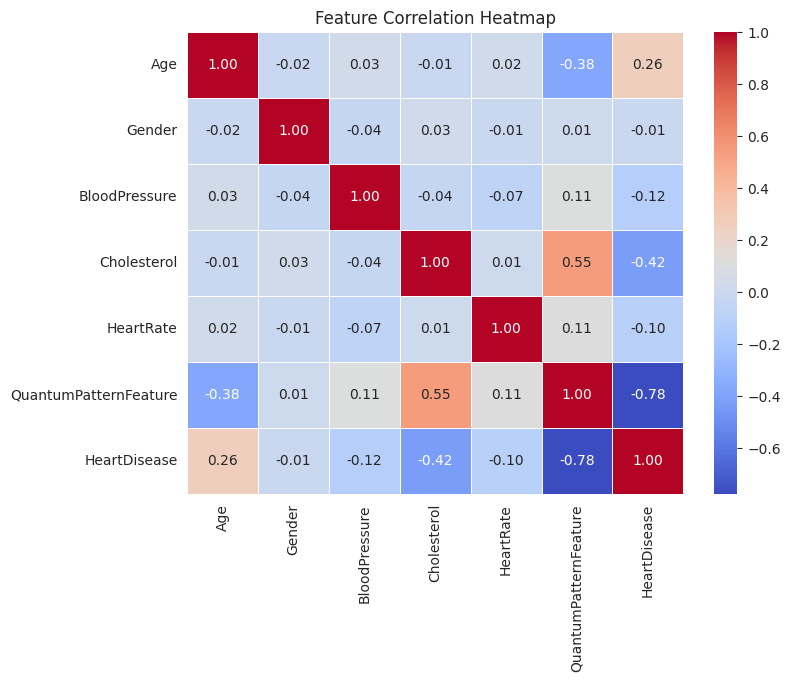

Plotting distributions by Heart Disease status...


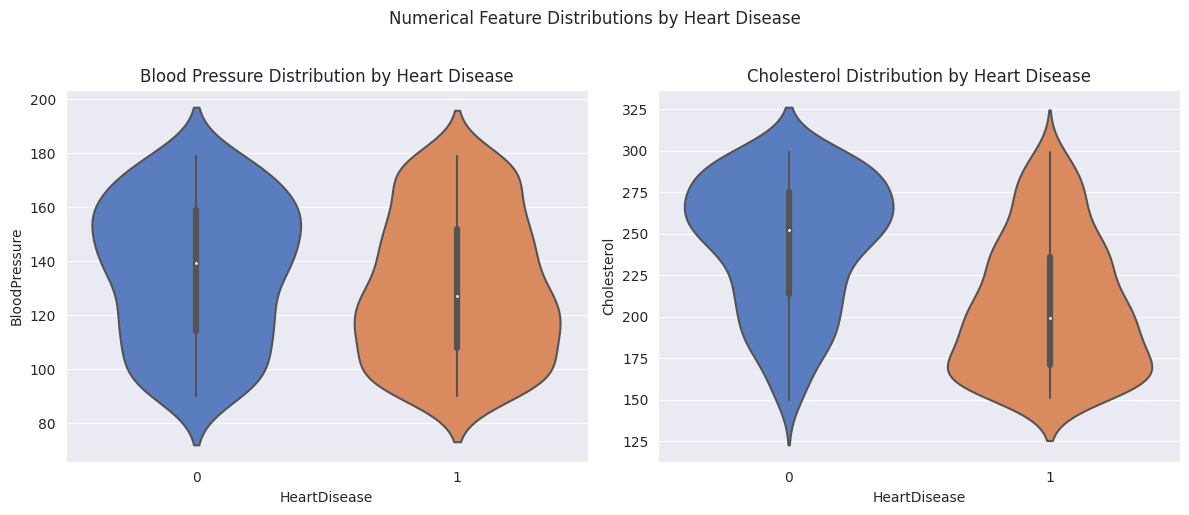

Plotting Heart Rate density by Heart Disease status...


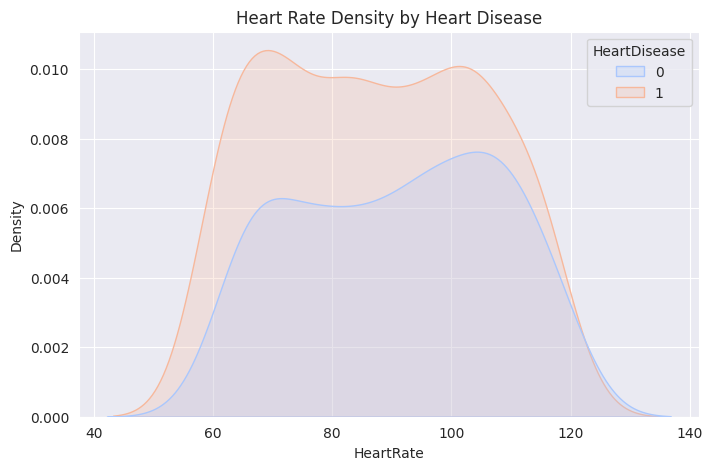

Plotting Quantum Pattern Feature relationships...


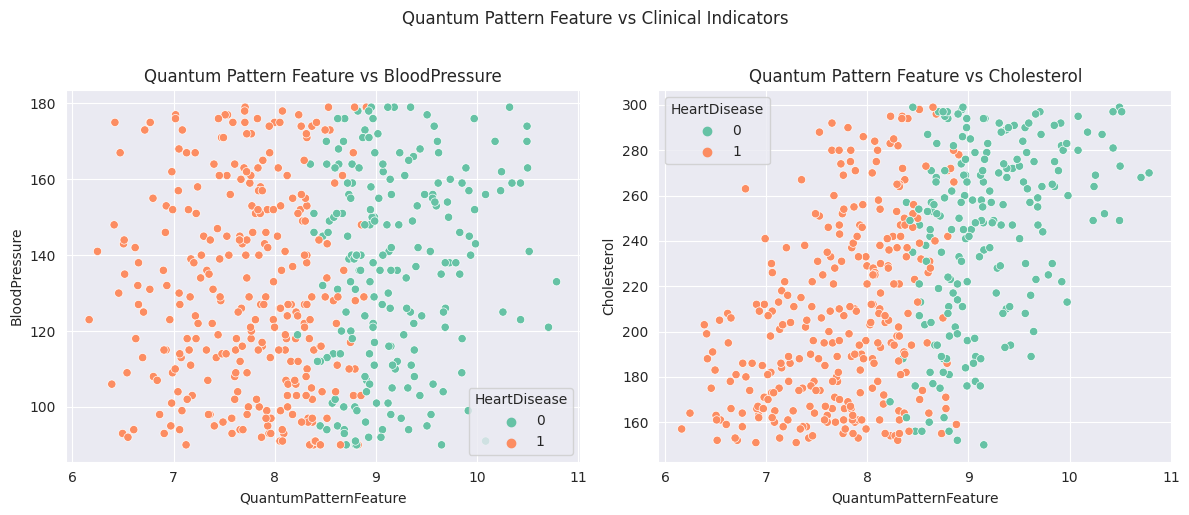

--- EDA Finished ---

--- 3. Classical Machine Learning Models ---
Setting up models and hyperparameter grids...
Performing RandomizedSearchCV (n_iter=20, cv=5)...

Tuning Logistic Regression...
Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}
Logistic Regression Test Accuracy: 0.9300
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.93      0.95      0.94        60

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



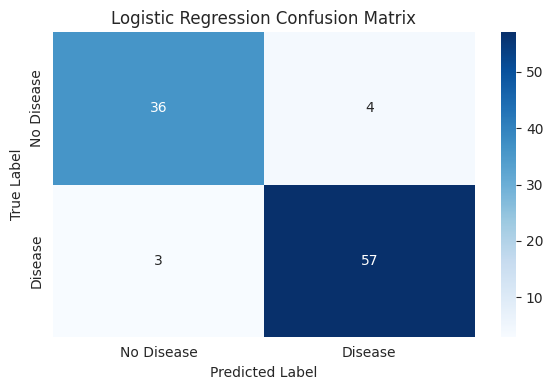

Logistic Regression tuning and evaluation took 2.61 seconds.

Tuning K-Nearest Neighbors...
Best parameters: {'weights': 'uniform', 'n_neighbors': 11, 'metric': 'manhattan'}
K-Nearest Neighbors Test Accuracy: 0.8300
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        40
           1       0.84      0.88      0.86        60

    accuracy                           0.83       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.83      0.83       100



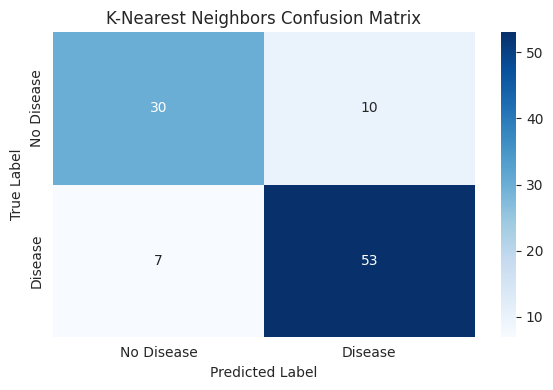

K-Nearest Neighbors tuning and evaluation took 0.57 seconds.

Tuning Decision Tree...
Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'gini'}
Decision Tree Test Accuracy: 0.8700
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        40
           1       0.90      0.88      0.89        60

    accuracy                           0.87       100
   macro avg       0.86      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



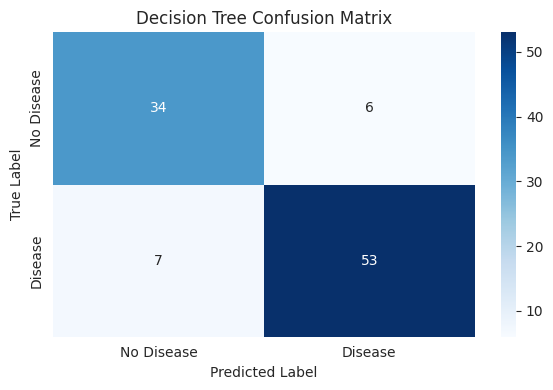

Decision Tree tuning and evaluation took 0.43 seconds.

Tuning Random Forest...
Best parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Random Forest Test Accuracy: 0.9200
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        40
           1       0.96      0.90      0.93        60

    accuracy                           0.92       100
   macro avg       0.91      0.93      0.92       100
weighted avg       0.92      0.92      0.92       100



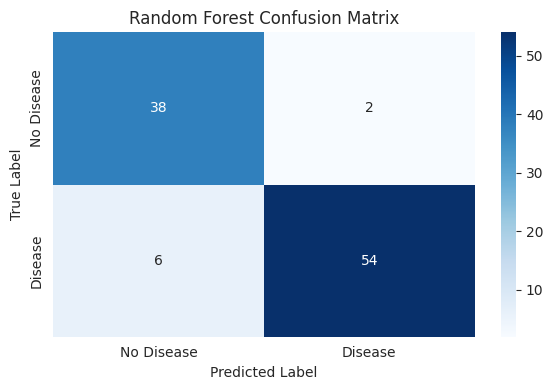

Random Forest tuning and evaluation took 6.89 seconds.

Tuning Naive Bayes...
Best parameters: {'var_smoothing': 1e-10}
Naive Bayes Test Accuracy: 0.9100
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        40
           1       0.93      0.92      0.92        60

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



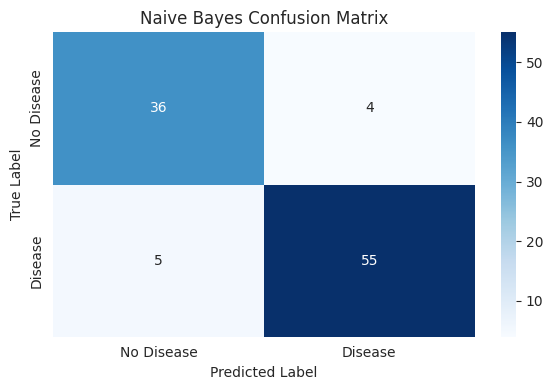

Naive Bayes tuning and evaluation took 0.31 seconds.

Tuning Gradient Boosting...
Best parameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05}
Gradient Boosting Test Accuracy: 0.9300
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        40
           1       0.95      0.93      0.94        60

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



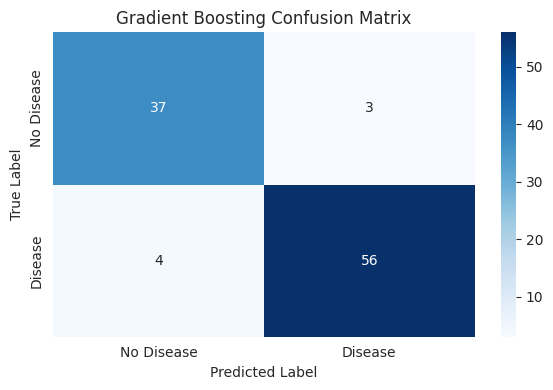

Gradient Boosting tuning and evaluation took 6.17 seconds.

--- Classical Model Tuning Finished ---

--- 4. Quantum Machine Learning (QSVM) ---
Setting up ZZFeatureMap with 6 features and reps=2...
Setting up Sampler primitive and FidelityQuantumKernel...
Instantiating and training QSVC (this may take time)...
QSVC training completed in 703.43 seconds.
Predicting on test set...
QSVC prediction completed in 357.92 seconds.

QSVC Performance:
Accuracy: 0.7900
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.68      0.72        40
           1       0.80      0.87      0.83        60

    accuracy                           0.79       100
   macro avg       0.79      0.77      0.78       100
weighted avg       0.79      0.79      0.79       100



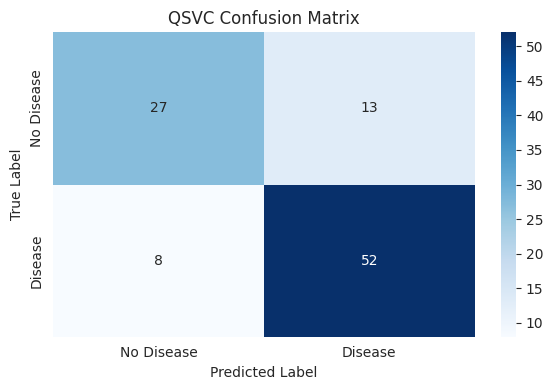

--- QSVM Finished ---

--- 5. Classical SVM Baseline ---
Instantiating and training classical SVC (RBF Kernel)...
Classical SVC training completed in 0.01 seconds.
Predicting on test set...
Classical SVC prediction completed in 0.00 seconds.

Classical SVC Performance:
Accuracy: 0.8900
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85        40
           1       0.87      0.97      0.91        60

    accuracy                           0.89       100
   macro avg       0.90      0.87      0.88       100
weighted avg       0.90      0.89      0.89       100



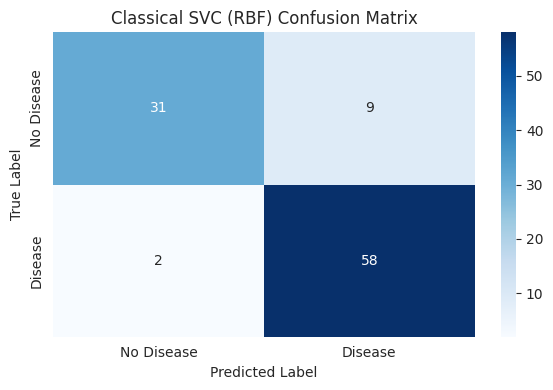

--- Classical SVM Baseline Finished ---

--- 6. Model Performance Comparison ---


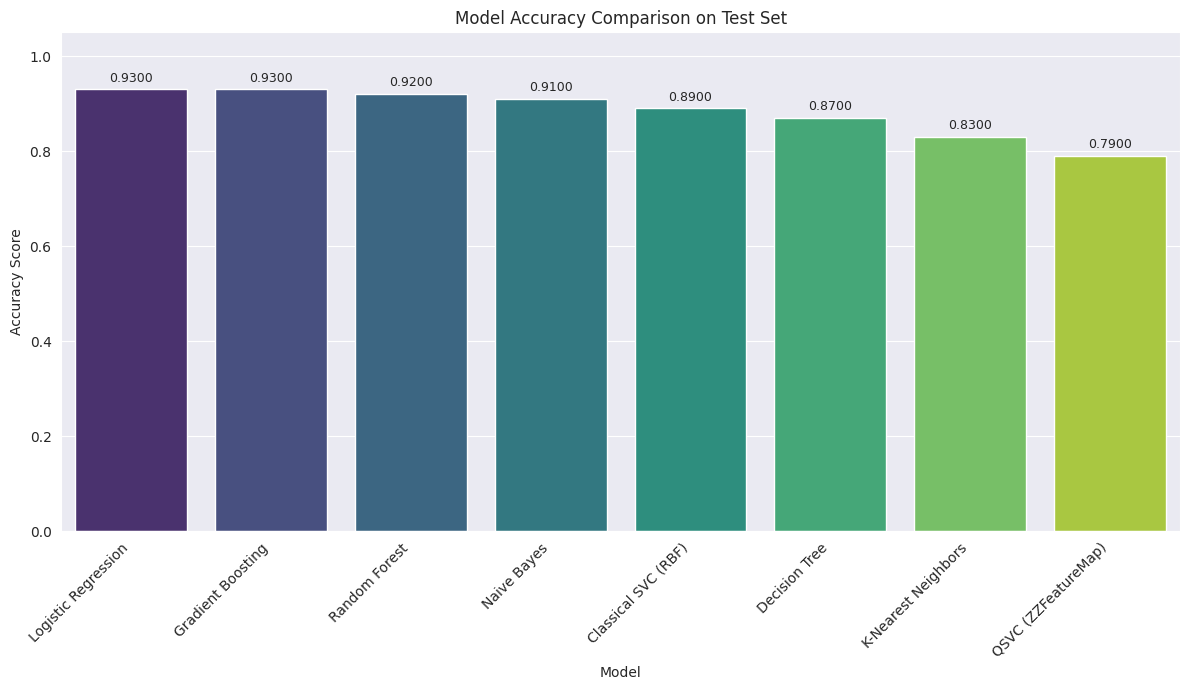


--- 7. Conclusion ---
Analysis complete. Classical models were tuned using RandomizedSearchCV.
QSVM using ZZFeatureMap and FidelityQuantumKernel was trained and evaluated.
Classical SVM with RBF kernel was used as a baseline.
Performance metrics (accuracy, classification reports) and confusion matrices were generated.

Note on QSVM:
  - Training time: 703.43s
  - Prediction time: 357.92s
  - This was run on a classical simulator. Performance on real quantum hardware may differ.
  - For this dataset size, classical methods are often faster and may perform comparably or better.

--- Analysis Finished ---


In [28]:

if __name__ == "__main__":
    main()